In [1]:
import sys
import rosbag
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [2]:
def getData(file,start_time,end_time,transition_stuff=[False,0,0,0]): #transition_stuff = [bool,int motor, float trigger_level, bool rising_edge]
	pos = []
	force = []
	time = []
	bag = rosbag.Bag(file)
	for topic, msg, t in bag.read_messages(topics=["/roboy/middleware/MotorStatus"]):
		pos.append(msg.position)
		force.append(msg.displacement)
		time.append(t.to_sec())
	bag.close()
	time = np.array(time)
	start_time -= time[0]
	end_time -= time[0]
	time -= time[0]
	#print start_time,end_time
	pos = np.array(pos)*position_to_rads
	force = np.array(force)*displacement_to_N
	result = []
	start_time = int(start_time/0.02)+1
	end_time = int(end_time/0.02)+1
	if transition_stuff[0]:
		transition_stuff[2] *= position_to_rads
		done = False
		prev = 0
		curr = 0
		while(not done):
			prev = pos[start_time-3:start_time,transition_stuff[1]].mean()
			curr = pos[start_time:start_time+3,transition_stuff[1]].mean()
			if transition_stuff[3]:
				if curr > transition_stuff[2] and prev < transition_stuff[2]:
					done = True
					break
			else:
				if curr < transition_stuff[2] and prev > transition_stuff[2]:
					done = True
					break
			start_time += 1
			end_time += 1
	result.append(pos[start_time:end_time])
	result.append(force[start_time:end_time])
	result.append(time[start_time:end_time])
	return result

In [5]:
global position_to_rads
global displacement_to_N
global base_files
global base_times
global matrix_filename_to_base_index

# obtain baseline
global fb_base
global fs_base
global sd_base
global baseline

path = "/home/roboy/dep_data/data/transitions/"
position_to_rads = 2.0*3.14159/(2000.0*53.0);
displacement_to_N = 0.237536
base_files = [path+"steps_fb_fs/0_rising/0_rising_2017-09-14-20-22-54.bag",path+"steps_fb_fs/0_rising/0_rising_2017-09-14-20-22-54.bag", path+"steps_fb_sd/0_rising/steps_fb_sd_0_rising_2017-09-14-23-37-30.bag"]
base_times = [(16.828+1505413374.96, 19.395+1505413374.96),(30.919+1505413374.96,33.516+1505413374.96),(37.353+1505425050.4,39.785+1505425050.4)]
matrix_filename_to_base_index = {'front_back.dep':0, 'front_side.dep':1, 'side_down.dep':2}

fb_base = getData(base_files[0],base_times[0][0],base_times[0][1])
fs_base = getData(base_files[1],base_times[1][0],base_times[1][1])
sd_base = getData(base_files[2],base_times[2][0],base_times[2][1])
baseline = [fb_base,fs_base,sd_base]

In [8]:
class transition:
	file = ''
	prev_m = ''
	m = ''
	baseline = []
	time = 0
	f_type = 0
	trigger = 0
	trigger_motor = 0
	trigger_level = 0
	trigger_edge = 0
	duration = 0
	start = 0
	end = 0
	data = []
	rms = 0

def getTransitions(file, cycles):
	bag = rosbag.Bag(file)
	trans = []
	for topic, msg, t in bag.read_messages(topics=["/roboy_dep/transition"]):
		tran = transition()
		tran.file = file
		tran.prev_m = msg.prev_filename
		tran.m = msg.matrix_filename
		if tran.m not in matrix_filename_to_base_index.keys():
			continue
		#print baseline[matrix_filename_to_base_index[tran.m]][0][:5,1]
		tran.base = baseline[matrix_filename_to_base_index[tran.m]]
	 	tran.f_type = msg.transition_type
	 	tran.trigger = msg.trigger_on
	 	tran.trigger_motor = msg.trigger_motor
	 	tran.trigger_level = msg.trigger_level
	 	tran.trigger_edge = msg.trigger_edge 		#rising (1) or falling (0)
	 	tran.duration = msg.duration
	 	tran.start = t.to_sec() #Note: this is not actual start of transition, rather the time when the command to transition was given (once trigger condition is met)
	 	tran.end = tran.start+(base_times[matrix_filename_to_base_index[tran.m]][1]-base_times[matrix_filename_to_base_index[tran.m]][0])*cycles
	 	temp = getData(file,tran.start,tran.end,transition_stuff=[True,tran.trigger_motor,tran.trigger_level,tran.trigger_edge])
	 	if temp != None:
	 		tran.data = temp
	 		trans.append(tran)
	bag.close()
	return trans

In [9]:
file = "/home/roboy/dep_data/data/transitions/steps_fb_sd/0_rising/steps_fb_sd_0_rising_2017-09-14-23-37-30.bag"
transitions = getTransitions(file, 5)

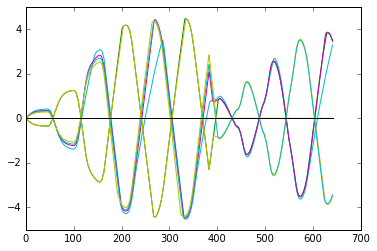

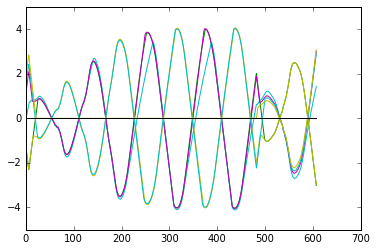

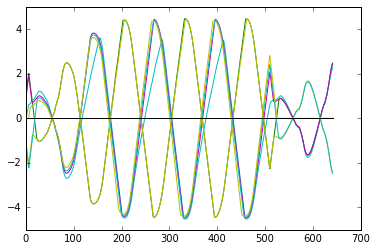

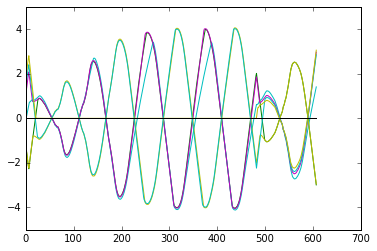

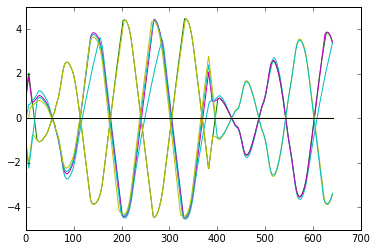

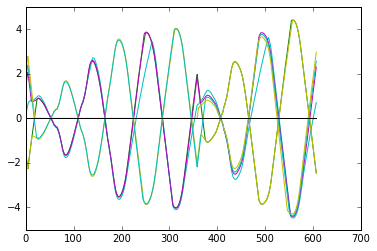

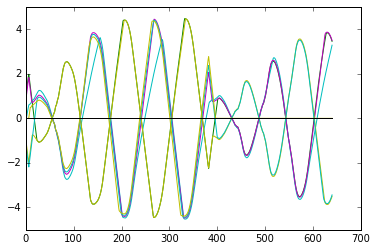

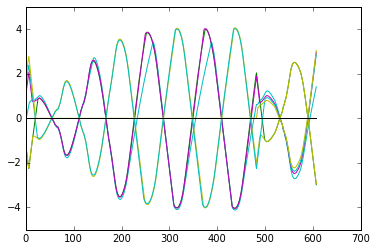

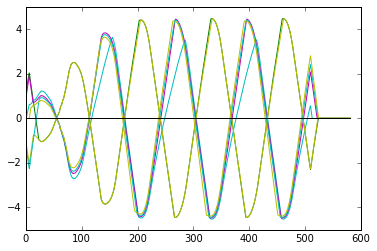

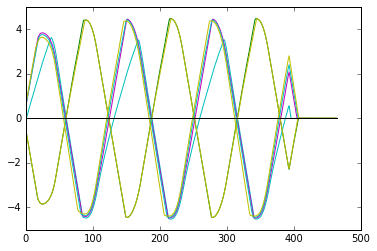

In [31]:
for transition in transitions:
    plt.figure(1)
    plt.plot(transition.data[0][:])
    plt.show()

In [32]:
def RMS(base, data):
	return np.sqrt(((base-data)**2).mean())

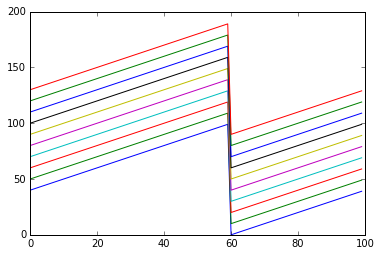

In [74]:
a = np.array(range(100))
b = []
for i in range(10):
    b.append(a+i*10)
b = np.transpose(np.array(b))
plt.figure(1)
plt.plot(np.roll(b,60,axis=0))
plt.show()

In [189]:
def allRMS(data,base):
    # calculate all RMS
    results = []
    for i in range(data.shape[0]):
        low = 1e9
        for k in range(base.shape[0]):
            RMS_ = 0
            for j in range(data.shape[1]):
                RMS_ += RMS(np.roll(base,k,axis=0)[:,j],np.roll(data,i,axis=0)[0:base.shape[0],j])
            if RMS_ < low:
                low = RMS_
        results.append(low)
    return results

In [190]:
data = transitions[1].data[0]
base = baseline[matrix_filename_to_base_index[transitions[1].m]][0]

In [191]:
results= allRMS(data,base)

In [192]:
results

[11.163261188569662,
 11.286633687850976,
 11.393825559473896,
 11.486439326737237,
 11.566427559160404,
 11.635222464848781,
 11.693674535741497,
 11.743070376642301,
 11.785076816872722,
 11.820876720778919,
 11.851129866862079,
 11.877037107731162,
 11.899147703519755,
 11.918243721306546,
 11.93536215170846,
 11.951497544809799,
 11.967300579278332,
 11.983730287078306,
 12.001595658224204,
 12.021746721987491,
 12.044779124284831,
 12.06922081161772,
 12.097422674682512,
 12.129995233481148,
 12.167372483736624,
 12.208195467725456,
 12.25347647373316,
 12.30404278150295,
 12.35980826691849,
 12.41874943604031,
 12.481849410062017,
 12.549398060066588,
 12.620834925376826,
 12.694769783526539,
 12.770120516327321,
 12.847595325818306,
 12.926368239278323,
 13.005535573434145,
 13.08440679390916,
 13.162595654048346,
 13.238711363432714,
 13.311475962844176,
 13.380604188661007,
 13.44605538481281,
 13.50602028486669,
 13.558984342869341,
 13.605275936471417,
 13.645369935582329,
 

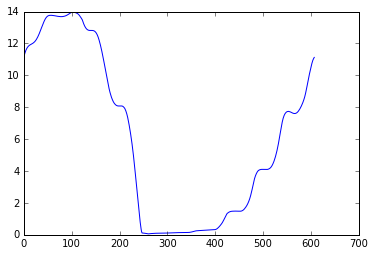

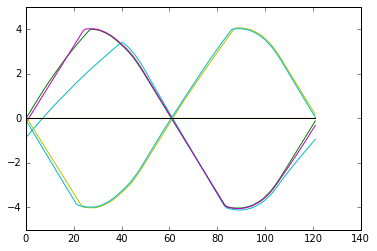

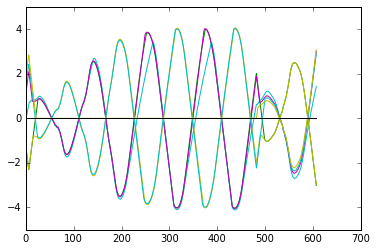

In [193]:
plt.figure(1)
plt.plot(results)

plt.figure(2)
plt.plot(base)

plt.figure(3)
plt.plot(np.roll(data,0,axis=0))

plt.show()